# Optimizers
**Recommended blogpost: http://ruder.io/optimizing-gradient-descent/index.html**  

So far we've used mini-batch stochastic gradient descent from `torch.optim.SGD` to minimize a loss funciton $J$.  
That's what happens when we run `optimizer.step()`:    
$\theta \gets \theta - \alpha * \nabla_\theta J(\theta; x, y)$  
Where $(x, y)$ - datapoints with corresponding labels/true values. $\theta$ - parameters we wish to optimize

However, it doesn't always provide the best direction for finding minimum

![sgd](without_momentum.gif)

^ The gradient is highest in vertical direction, but we should move in horizontal direction

Other methods can find minimum faster:

![optimizers](contours_evaluation_optimizers.gif)  
And are more robust to non-convex functions, e.g. saddle points  
![saddle point](saddle_point_evaluation_optimizers.gif)

# Cats vs dogs - different optimizers
Code based on previous tutorials

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize, Compose

target_size = (32, 32)
batch_size = 32

transforms = Compose([Resize(target_size), # Resizes image
                    ToTensor(),           # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                    Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5)), # scales to [-1.0, 1.0]
                    ])

# Load train data
root_dir = '../dogscats/train'
train_dataset = ImageFolder(root_dir, transform=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=32)

# Load validation data
val_root_dir = '../dogscats/valid'
val_dataset = ImageFolder(val_root_dir, transform=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    
class MLPModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )
    
    def forward(self, input):
        input = input.view(input.size(0), -1)
        return self.layers(input)
    
from utils_train import fit # Defined in utils_train.py

# Train with different optimizers
https://pytorch.org/docs/stable/optim.html#algorithms

In [2]:
training_curves = {}

## SGD
https://pytorch.org/docs/stable/optim.html#torch.optim.SGD

In [3]:
model = MLPModel(32*32*3, 128)
model = model.to(device)
learning_rate = 0.01
## STANDARD SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

curves = fit(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs)
training_curves['sgd'] = curves

Epoch 1/25: train_loss: 0.6868, train_accuracy: 55.6913, val_loss: 0.6777, val_accuracy: 58.7500
Epoch 2/25: train_loss: 0.6629, train_accuracy: 61.9130, val_loss: 0.6533, val_accuracy: 61.5000
Epoch 3/25: train_loss: 0.6363, train_accuracy: 64.2348, val_loss: 0.6427, val_accuracy: 62.3000
Epoch 4/25: train_loss: 0.6195, train_accuracy: 65.6304, val_loss: 0.6279, val_accuracy: 63.9000
Epoch 5/25: train_loss: 0.6042, train_accuracy: 66.9870, val_loss: 0.6190, val_accuracy: 65.4000
Epoch 6/25: train_loss: 0.5914, train_accuracy: 68.3087, val_loss: 0.6129, val_accuracy: 65.2500
Epoch 7/25: train_loss: 0.5781, train_accuracy: 69.7652, val_loss: 0.6096, val_accuracy: 67.2000
Epoch 8/25: train_loss: 0.5644, train_accuracy: 70.6261, val_loss: 0.6189, val_accuracy: 65.3000
Epoch 9/25: train_loss: 0.5547, train_accuracy: 71.3652, val_loss: 0.6067, val_accuracy: 67.1500
Epoch 10/25: train_loss: 0.5419, train_accuracy: 72.5652, val_loss: 0.6124, val_accuracy: 66.7500
Epoch 11/25: train_loss: 0.53

## SGD with momentum
https://pytorch.org/docs/stable/optim.html#torch.optim.SGD

In [4]:
# Reinitialize model 
model = MLPModel(32*32*3, 128)
model = model.to(device)
learning_rate = 0.01
## SGD WITH MOMENTUM
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

curves = fit(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs)
training_curves['sgd_momentum'] = curves

Epoch 1/25: train_loss: 0.6534, train_accuracy: 60.6696, val_loss: 0.6324, val_accuracy: 65.0500
Epoch 2/25: train_loss: 0.6174, train_accuracy: 65.5043, val_loss: 0.6264, val_accuracy: 64.2000
Epoch 3/25: train_loss: 0.5976, train_accuracy: 67.1609, val_loss: 0.6177, val_accuracy: 66.3500
Epoch 4/25: train_loss: 0.5791, train_accuracy: 69.1826, val_loss: 0.6133, val_accuracy: 65.5500
Epoch 5/25: train_loss: 0.5606, train_accuracy: 70.9043, val_loss: 0.6084, val_accuracy: 67.6500
Epoch 6/25: train_loss: 0.5459, train_accuracy: 71.8609, val_loss: 0.6081, val_accuracy: 65.9000
Epoch 7/25: train_loss: 0.5292, train_accuracy: 72.9000, val_loss: 0.6150, val_accuracy: 66.7500
Epoch 8/25: train_loss: 0.5075, train_accuracy: 74.2957, val_loss: 0.6189, val_accuracy: 66.7500
Epoch 9/25: train_loss: 0.4913, train_accuracy: 75.7522, val_loss: 0.6308, val_accuracy: 66.9500
Epoch 10/25: train_loss: 0.4754, train_accuracy: 76.0870, val_loss: 0.6549, val_accuracy: 66.6500
Epoch 11/25: train_loss: 0.45

## SGD with Nesterov Momentum
https://pytorch.org/docs/stable/optim.html#torch.optim.SGD

In [5]:
# Reinitialize model 
model = MLPModel(32*32*3, 128)
model = model.to(device)
learning_rate = 0.01
## SGD WITH NESTEROV MOMENTUM
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

curves = fit(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs)
training_curves['sgd_nesterov'] = curves

Epoch 1/25: train_loss: 0.6498, train_accuracy: 61.3435, val_loss: 0.6331, val_accuracy: 64.0000
Epoch 2/25: train_loss: 0.6147, train_accuracy: 65.6696, val_loss: 0.6199, val_accuracy: 65.4500
Epoch 3/25: train_loss: 0.5930, train_accuracy: 67.7609, val_loss: 0.6151, val_accuracy: 66.5000
Epoch 4/25: train_loss: 0.5759, train_accuracy: 69.4696, val_loss: 0.6257, val_accuracy: 65.8500
Epoch 5/25: train_loss: 0.5586, train_accuracy: 70.9043, val_loss: 0.5998, val_accuracy: 67.4500
Epoch 6/25: train_loss: 0.5376, train_accuracy: 72.2435, val_loss: 0.6217, val_accuracy: 65.6500
Epoch 7/25: train_loss: 0.5212, train_accuracy: 73.6565, val_loss: 0.6066, val_accuracy: 66.2000
Epoch 8/25: train_loss: 0.5007, train_accuracy: 74.7304, val_loss: 0.6606, val_accuracy: 66.1000
Epoch 9/25: train_loss: 0.4812, train_accuracy: 75.9696, val_loss: 0.6392, val_accuracy: 65.2500
Epoch 10/25: train_loss: 0.4630, train_accuracy: 77.3435, val_loss: 0.6461, val_accuracy: 65.6500
Epoch 11/25: train_loss: 0.43

## Adagrad
https://pytorch.org/docs/stable/optim.html#torch.optim.Adagrad

In [6]:
# Reinitialize model 
model = MLPModel(32*32*3, 128)
model = model.to(device)
learning_rate = 0.01
## ADAGRAD
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

curves = fit(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs)
training_curves['adagrad_lr0.01'] = curves

Epoch 1/25: train_loss: 0.6501, train_accuracy: 61.8913, val_loss: 0.6327, val_accuracy: 63.2000
Epoch 2/25: train_loss: 0.6037, train_accuracy: 66.7739, val_loss: 0.6146, val_accuracy: 65.3500
Epoch 3/25: train_loss: 0.5736, train_accuracy: 69.5261, val_loss: 0.6068, val_accuracy: 66.0500
Epoch 4/25: train_loss: 0.5466, train_accuracy: 71.7435, val_loss: 0.6205, val_accuracy: 65.5500
Epoch 5/25: train_loss: 0.5180, train_accuracy: 73.7826, val_loss: 0.6176, val_accuracy: 67.1000
Epoch 6/25: train_loss: 0.4874, train_accuracy: 76.2087, val_loss: 0.6249, val_accuracy: 65.7000
Epoch 7/25: train_loss: 0.4541, train_accuracy: 78.1000, val_loss: 0.6434, val_accuracy: 66.2500
Epoch 8/25: train_loss: 0.4211, train_accuracy: 80.5870, val_loss: 0.6725, val_accuracy: 66.1000
Epoch 9/25: train_loss: 0.3862, train_accuracy: 82.3217, val_loss: 0.6957, val_accuracy: 66.4500
Epoch 10/25: train_loss: 0.3519, train_accuracy: 84.3565, val_loss: 0.7415, val_accuracy: 64.9000
Epoch 11/25: train_loss: 0.31

## RMSprop
https://pytorch.org/docs/stable/optim.html#torch.optim.RMSprop

In [7]:
# Reinitialize model 
model = MLPModel(32*32*3, 128)
model = model.to(device)
learning_rate = 0.001 # doesn't work with 0.01
## ADAGRAD
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

curves = fit(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs)
training_curves['rmsprop'] = curves

Epoch 1/25: train_loss: 0.6534, train_accuracy: 61.5652, val_loss: 0.6424, val_accuracy: 62.7500
Epoch 2/25: train_loss: 0.6181, train_accuracy: 65.6304, val_loss: 0.6211, val_accuracy: 65.3500
Epoch 3/25: train_loss: 0.5946, train_accuracy: 67.5783, val_loss: 0.6626, val_accuracy: 65.4500
Epoch 4/25: train_loss: 0.5718, train_accuracy: 69.8696, val_loss: 0.6251, val_accuracy: 66.3500
Epoch 5/25: train_loss: 0.5467, train_accuracy: 71.3609, val_loss: 0.6430, val_accuracy: 66.5000
Epoch 6/25: train_loss: 0.5254, train_accuracy: 73.0783, val_loss: 0.6536, val_accuracy: 68.8500
Epoch 7/25: train_loss: 0.4976, train_accuracy: 74.9261, val_loss: 0.6655, val_accuracy: 66.3500
Epoch 8/25: train_loss: 0.4672, train_accuracy: 76.9870, val_loss: 0.6868, val_accuracy: 65.0000
Epoch 9/25: train_loss: 0.4423, train_accuracy: 78.1435, val_loss: 0.6888, val_accuracy: 66.8500
Epoch 10/25: train_loss: 0.4116, train_accuracy: 80.1652, val_loss: 0.7456, val_accuracy: 65.3500
Epoch 11/25: train_loss: 0.38

## ADAM
https://pytorch.org/docs/stable/optim.html#torch.optim.Adam

In [8]:
# Reinitialize model 
model = MLPModel(32*32*3, 128)
model = model.to(device)
learning_rate = 0.0001 # 0.01 too big for this network
## ADAM // betas=(0.9, 0.999) - default parameters
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

curves = fit(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs)
training_curves['adam'] = curves

Epoch 1/25: train_loss: 0.6528, train_accuracy: 60.4652, val_loss: 0.6325, val_accuracy: 62.8500
Epoch 2/25: train_loss: 0.6158, train_accuracy: 65.4870, val_loss: 0.6217, val_accuracy: 64.6000
Epoch 3/25: train_loss: 0.5902, train_accuracy: 68.4478, val_loss: 0.6096, val_accuracy: 66.7000
Epoch 4/25: train_loss: 0.5688, train_accuracy: 70.5957, val_loss: 0.6115, val_accuracy: 66.4500
Epoch 5/25: train_loss: 0.5495, train_accuracy: 71.9087, val_loss: 0.5982, val_accuracy: 68.3500
Epoch 6/25: train_loss: 0.5298, train_accuracy: 73.6261, val_loss: 0.6136, val_accuracy: 68.1500
Epoch 7/25: train_loss: 0.5079, train_accuracy: 74.9565, val_loss: 0.6151, val_accuracy: 66.8500
Epoch 8/25: train_loss: 0.4882, train_accuracy: 76.5348, val_loss: 0.6237, val_accuracy: 67.4000
Epoch 9/25: train_loss: 0.4647, train_accuracy: 78.2304, val_loss: 0.6409, val_accuracy: 66.7000
Epoch 10/25: train_loss: 0.4431, train_accuracy: 79.4957, val_loss: 0.6568, val_accuracy: 67.0000
Epoch 11/25: train_loss: 0.41

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

## Training losses and accuracies

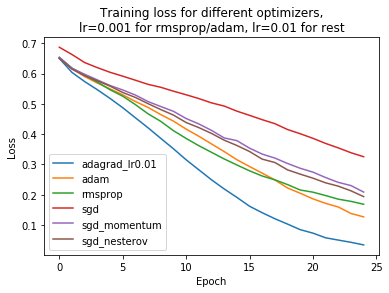

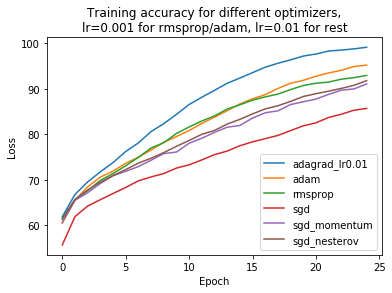

In [10]:
keys = []
for k, v in sorted(training_curves.items()):
    plt.plot(np.arange(len(v[0])), v[0])
    keys.append(k)
plt.title('Training loss for different optimizers,\nlr=0.001 for rmsprop/adam, lr=0.01 for rest')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(keys);

plt.figure()
keys = []
for k, v in sorted(training_curves.items()):
    plt.plot(np.arange(len(v[1])), v[1])
    keys.append(k)
plt.title('Training accuracy for different optimizers,\nlr=0.001 for rmsprop/adam, lr=0.01 for rest')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(keys);

**Much faster training with momentum and adaptive optimizers!**

## Validation losses and accuracies

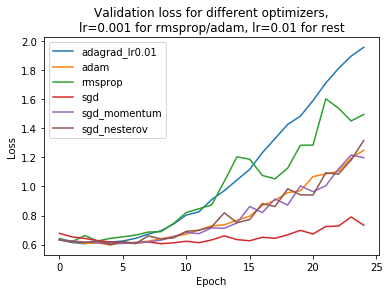

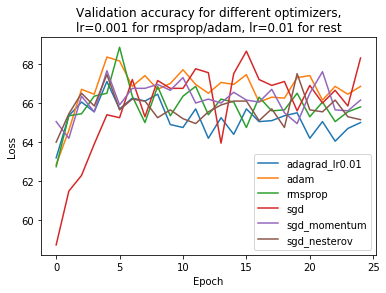

In [11]:
keys = []
for k, v in sorted(training_curves.items()):
    plt.plot(np.arange(len(v[2])), v[2])
    keys.append(k)
plt.title('Validation loss for different optimizers,\nlr=0.001 for rmsprop/adam, lr=0.01 for rest')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(keys);

plt.figure()
keys = []
for k, v in sorted(training_curves.items()):
    plt.plot(np.arange(len(v[3])), v[3])
    keys.append(k)
plt.title('Validation accuracy for different optimizers,\nlr=0.001 for rmsprop/adam, lr=0.01 for rest')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(keys);

On validation set, we can observe **overfitting** much faster

# Which optimizer to use?
Depends on the problem but often **ADAM** is a good default option (http://ruder.io/optimizing-gradient-descent/index.html#whichoptimizertochoose)

# Learning rate schedules
Often it's good to start with relatively large learning rate when we start the training and are far from optimum, and lower it when we're getting closer -- make smaller steps to reach the minimum.

## Possible learning rate schedules
Also implemented in PyTorch: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

### Step
Reduce learning rate after a certain number of epochs

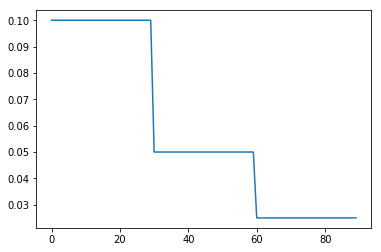

In [12]:
lr = [0.1 for i in range(30)] + [0.05 for i in range(30)] + [0.025 for i in range(30)]
plt.plot(np.arange(90), lr)

### Exponential
Multiply by gamma < 1 after every epoch

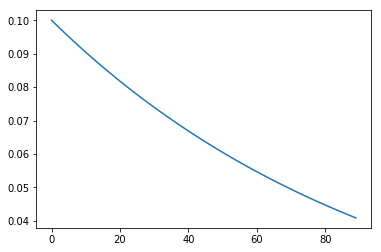

In [13]:
gamma = 0.99
lr = [0.1 * gamma ** i for i in range(90)]
plt.plot(np.arange(90), lr)

### Cosine annealing
Starts decreasing slowly, than slowly reaches minimum

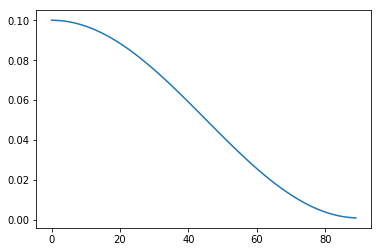

In [14]:
import math
base_lr = 0.1
max_iterations = 90
min_lr = 0.001
lr = [min_lr + (base_lr - min_lr) *
                (1 + math.cos(math.pi * i / max_iterations)) / 2 for i in range(90)]
plt.plot(np.arange(90), lr)

### ReduceLR on plateau
Monitor loss/accuracy, reduce learning rate when it stops training

# Learning rate schedule examples

## Reduce every 10 epochs

In [15]:
# Reinitialize model 
model = MLPModel(32*32*3, 128)
model = model.to(device)
learning_rate = 0.05
## ADAM // betas=(0.9, 0.999) - default parameters
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

In [16]:
from utils_train import train, test
def fit(train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs, scheduler=None):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    learning_rates = []
    for epoch in range(n_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
        val_loss, val_accuracy = test(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        # We'll monitor learning rate -- just to show that it's decreasing
        learning_rates.append(optimizer.param_groups[0]['lr'])
        ########## Notify a scheduler that an epoch passed
        if scheduler:
            scheduler.step() # argument only needed for ReduceLROnPlateau
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                          train_losses[-1],
                                                                                                          train_accuracies[-1],
                                                                                                          val_losses[-1],
                                                                                                          val_accuracies[-1]))
    
    return train_losses, train_accuracies, val_losses, val_accuracies, learning_rates

https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR

In [17]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1) 

In [18]:
curves_lr_scheduler = fit(train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs, scheduler)

Epoch 1/25: train_loss: 0.6614, train_accuracy: 60.1913, val_loss: 0.6393, val_accuracy: 61.7000
Epoch 2/25: train_loss: 0.6332, train_accuracy: 63.9565, val_loss: 0.6397, val_accuracy: 63.2000
Epoch 3/25: train_loss: 0.6165, train_accuracy: 65.6391, val_loss: 0.6235, val_accuracy: 63.6500
Epoch 4/25: train_loss: 0.6085, train_accuracy: 66.7870, val_loss: 0.6364, val_accuracy: 66.0500
Epoch 5/25: train_loss: 0.5970, train_accuracy: 68.1522, val_loss: 0.6398, val_accuracy: 63.3500
Epoch 6/25: train_loss: 0.5851, train_accuracy: 69.3043, val_loss: 0.6302, val_accuracy: 64.9000
Epoch 7/25: train_loss: 0.5795, train_accuracy: 69.4043, val_loss: 0.6460, val_accuracy: 63.7000
Epoch 8/25: train_loss: 0.5699, train_accuracy: 70.1870, val_loss: 0.6319, val_accuracy: 64.8000
Epoch 9/25: train_loss: 0.5608, train_accuracy: 71.3217, val_loss: 0.6499, val_accuracy: 66.0500
Epoch 10/25: train_loss: 0.5470, train_accuracy: 71.9348, val_loss: 0.6328, val_accuracy: 65.2000
Epoch 11/25: train_loss: 0.47

In [19]:
# Reinitialize model 
model = MLPModel(32*32*3, 128)
model = model.to(device)
learning_rate = 0.05
## ADAM // betas=(0.9, 0.999) - default parameters
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()
curves_constant_lr = fit(train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs)

Epoch 1/25: train_loss: 0.6606, train_accuracy: 60.1000, val_loss: 0.6428, val_accuracy: 61.7000
Epoch 2/25: train_loss: 0.6333, train_accuracy: 63.5391, val_loss: 0.6388, val_accuracy: 62.6500
Epoch 3/25: train_loss: 0.6186, train_accuracy: 65.4174, val_loss: 0.6150, val_accuracy: 65.3500
Epoch 4/25: train_loss: 0.6083, train_accuracy: 67.0478, val_loss: 0.6380, val_accuracy: 61.8500
Epoch 5/25: train_loss: 0.5998, train_accuracy: 67.5957, val_loss: 0.6442, val_accuracy: 62.9500
Epoch 6/25: train_loss: 0.5902, train_accuracy: 68.6000, val_loss: 0.6194, val_accuracy: 65.0500
Epoch 7/25: train_loss: 0.5766, train_accuracy: 69.4261, val_loss: 0.6468, val_accuracy: 63.5000
Epoch 8/25: train_loss: 0.5677, train_accuracy: 70.1826, val_loss: 0.6568, val_accuracy: 65.2500
Epoch 9/25: train_loss: 0.5667, train_accuracy: 70.7043, val_loss: 0.6532, val_accuracy: 65.3500
Epoch 10/25: train_loss: 0.5479, train_accuracy: 72.0087, val_loss: 0.6634, val_accuracy: 64.8000
Epoch 11/25: train_loss: 0.54

Text(0.5, 1.0, 'Step learning rate schedule')

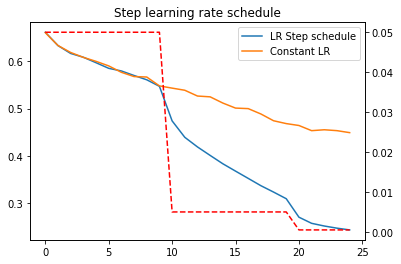

In [20]:
fig, ax1 = plt.subplots()
x = np.arange(25)
ax1.plot(curves_lr_scheduler[0]) # training loss
ax1.plot(curves_constant_lr[0])
ax1.legend(['LR Step schedule', 'Constant LR'])
ax2 = ax1.twinx()
ax2.plot(curves_lr_scheduler[4], 'r--') #learning rates
plt.title('Step learning rate schedule')

**We can see faster training when we decreased learning rate**